#Iniciando o projeto: configurações iniciais

In [101]:
import numpy as np
import pandas as pd
import os

In [102]:
seed = 19
np.random.seed(seed)

In [103]:
%matplotlib inline 
import matplotlib as mpl 
import matplotlib.pyplot as plt 

mpl.rc('axes', labelsize=14) 
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [104]:
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Obtendo e descrevendo o conjunto de dados

In [105]:
data_url = 'http://lib.stat.cmu.edu/datasets/boston'
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :3]])
feature_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
boston = pd.DataFrame(data, columns=feature_names)

Em que:

CRIM - per capita crime rate by town

ZN - proportion of residential land zoned for lots over 25,000 sq.ft.

INDUS - proportion of non-retail business acres per town.

CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)

NOX - nitric oxides concentration (parts per 10 million)

RM - average number of rooms per dwelling

AGE - proportion of owner-occupied units built prior to 1940

DIS - weighted distances to five Boston employment centres

RAD - index of accessibility to radial highways

TAX - full-value property-tax rate per \$10,000

PTRATIO - pupil-teacher ratio by town

B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town

LSTAT - % lower status of the population

MEDV - Median value of owner-occupied homes in \$1000's




Vamos vizualizar o formato dos nossos dados:

In [106]:
boston.sample(n = 5, random_state = seed)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
38,0.17505,0.0,5.96,0.0,0.499,5.966,30.2,3.8473,5.0,279.0,19.2,393.43,10.13,24.7
10,0.22489,12.5,7.87,0.0,0.524,6.377,94.3,6.3467,5.0,311.0,15.2,392.52,20.45,15.0
142,3.32105,0.0,19.58,1.0,0.871,5.403,100.0,1.3216,5.0,403.0,14.7,396.90,26.82,13.4
235,0.33045,0.0,6.20,0.0,0.507,6.086,61.5,3.6519,8.0,307.0,17.4,376.75,10.88,24.0
350,0.06211,40.0,1.25,0.0,0.429,6.490,44.4,8.7921,1.0,335.0,19.7,396.90,5.98,22.9


In [107]:
boston.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


Note que todas as variáveis estão no formato float64. Plotaremos alguns histogramas para compreendermos melhor o problema:

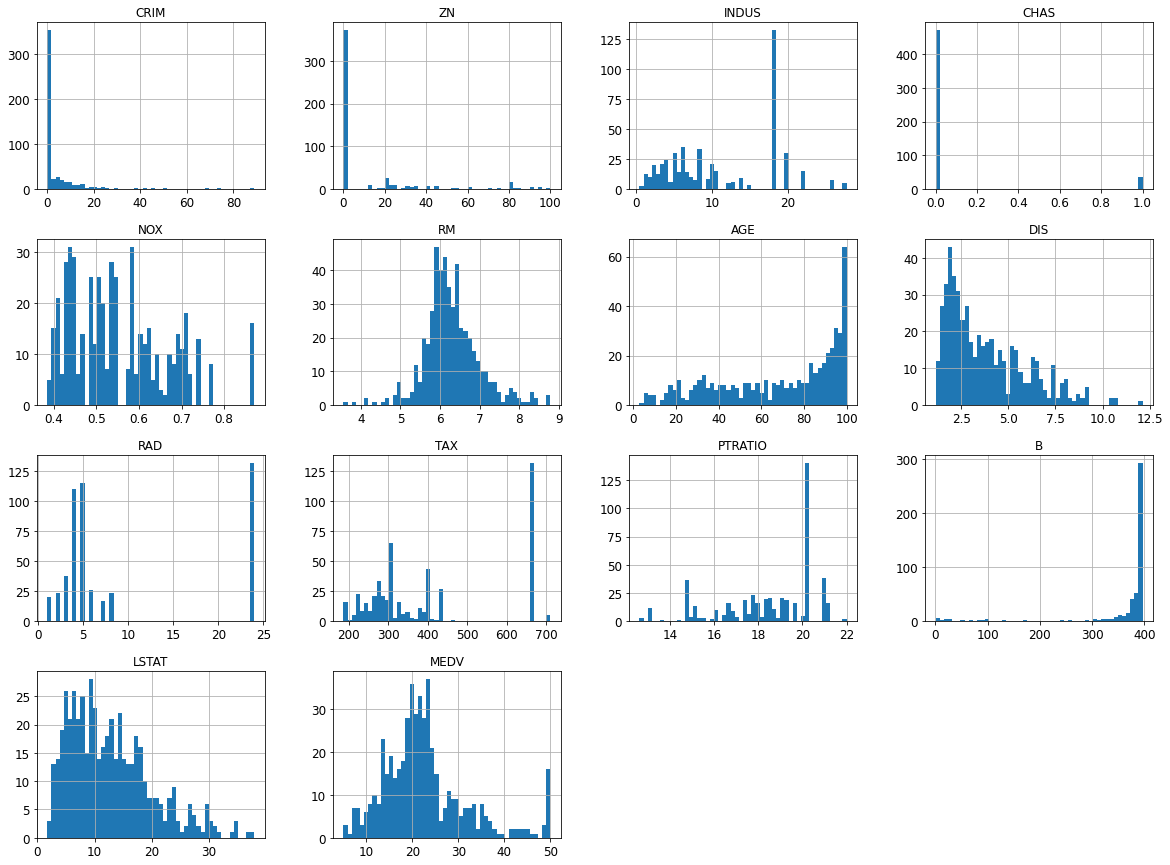

In [108]:
%matplotlib inline
import matplotlib.pyplot as plt
boston.hist(bins=50, figsize=(20,15))
plt.show()

#Separando o conjunto de dados

Agora pegaremos o conjunto de dados e dividiremos em dois subconjuntos: treinamento e teste. Para isso, vamos embaralhar os dados na ordem aleatória previamente fixada para remover qualquer viés na ordenação do conjunto de dados.

In [109]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(boston, 
                                       test_size=0.2, #20% para teste
                                       random_state=seed)

Essa divisão é puramente aleatória. Vejamos algumas informações sobre o parametro RM.

In [110]:
boston["RM"].describe()

count    506.000000
mean       6.284634
std        0.702617
min        3.561000
25%        5.885500
50%        6.208500
75%        6.623500
max        8.780000
Name: RM, dtype: float64

In [111]:
mean = np.mean(boston["RM"])
std = np.std(boston["RM"])

Vamos optar por um feature engineering neste momento. Dividiremos o número de quartos em 5 conjuntos, como abaixo:

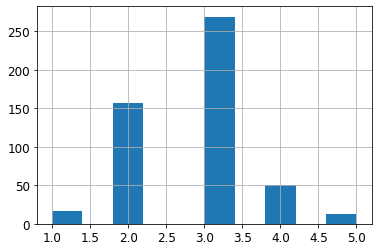

In [112]:
boston["room_strat"] = pd.cut(boston["RM"],
                               bins=[0., 5., 6., 7., 8., np.inf],
                               labels=[1, 2, 3, 4, 5])

boston["room_strat"].hist()

In [113]:
boston["room_strat"].value_counts()

3    269
2    157
4     51
1     16
5     13
Name: room_strat, dtype: int64

In [114]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)

for train_index, test_index in split.split(boston, boston["room_strat"]):
    strat_train_set = boston.loc[train_index]
    strat_test_set = boston.loc[test_index]

Criamos novos conjuntos de treino e de teste, que chamamos de strat_train_set e strat_test_set. Estes conjuntos devem respeitar a separação que introduzimos baseada em "RM" representado na nova variável "room_strat".

In [115]:
def income_cat_proportions(data): 
    return data["room_strat"].value_counts()/len(data)

In [116]:
train_set, test_set = train_test_split(boston, test_size=0.2, random_state=seed)

In [117]:
compare_props = pd.DataFrame({
    "Geral": income_cat_proportions(boston),
    "Estratificado": income_cat_proportions(strat_test_set),
    "Aleatorio": income_cat_proportions(test_set),
}).sort_index()

compare_props["Aleatório %erro"] = 100*compare_props["Aleatorio"]/compare_props["Geral"] - 100
compare_props["Estratificado %erro"] = 100*compare_props["Estratificado"]/compare_props["Geral"] - 100

compare_props

,Geral,Estratificado,Aleatorio,Aleatório %erro,Estratificado %erro
1,0.031621,0.029412,0.029412,-6.985294,-6.985294
2,0.310277,0.313725,0.343137,10.590733,1.111527
3,0.531621,0.529412,0.509804,-4.103798,-0.415482
4,0.100791,0.098039,0.078431,-22.183775,-2.729719
5,0.025692,0.029412,0.039216,52.639517,14.479638


Como o resultado ficou consideravelmente melhor que o original, removemos o parametro intermediário 'room_strat' de strat_train_set e de strat_test_set.

In [118]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("room_strat", axis=1, inplace=True)

# Visualizando a estrutura de dados

Aqui analisaremos algumas propriedades dos nossos dados. Entretanto, queremos evitar o fenômeno do **SNOOPING BIAS**. Para isso, vizualizaremos somente o conjunto de treino, ignorando a existência do conjunto de teste.

In [119]:
boston = strat_train_set.copy()

In [120]:
corr_matrix = boston.corr()

corr_matrix

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
CRIM,1.000000,-0.203462,0.395715,-0.054805,0.432078,-0.199139,0.361322,-0.381070,0.612165,0.571355,0.297793,-0.314003,0.479028,-0.392197
ZN,-0.203462,1.000000,-0.554188,-0.046751,-0.545092,0.320000,-0.593504,0.676621,-0.328190,-0.326620,-0.392645,0.177692,-0.422488,0.371187
INDUS,0.395715,-0.554188,1.000000,0.085003,0.783959,-0.397297,0.678480,-0.734869,0.593144,0.704537,0.364306,-0.354427,0.608592,-0.474546
CHAS,-0.054805,-0.046751,0.085003,1.000000,0.122409,0.101050,0.105227,-0.123777,-0.001140,-0.023592,-0.130801,0.047125,-0.070077,0.190827
NOX,0.432078,-0.545092,0.783959,0.122409,1.000000,-0.347257,0.738272,-0.778721,0.624051,0.684684,0.233710,-0.395940,0.615901,-0.458808
RM,-0.199139,0.320000,-0.397297,0.101050,-0.347257,1.000000,-0.261281,0.224891,-0.198890,-0.279592,-0.314851,0.100897,-0.629316,0.696873
AGE,0.361322,-0.593504,0.678480,0.105227,0.738272,-0.261281,1.000000,-0.743845,0.477287,0.531716,0.285567,-0.283260,0.606988,-0.396675
DIS,-0.381070,0.676621,-0.734869,-0.123777,-0.778721,0.224891,-0.743845,1.000000,-0.508479,-0.556623,-0.262986,0.294458,-0.503396,0.268609
RAD,0.612165,-0.328190,0.593144,-0.001140,0.624051,-0.198890,0.477287,-0.508479,1.000000,0.912531,0.495899,-0.415246,0.500730,-0.372652
TAX,0.571355,-0.326620,0.704537,-0.023592,0.684684,-0.279592,0.531716,-0.556623,0.912531,1.000000,0.469742,-0.422019,0.548827,-0.450956


In [121]:
corr_matrix["MEDV"].sort_values(ascending=False)

MEDV       1.000000
RM         0.696873
ZN         0.371187
B          0.327455
DIS        0.268609
CHAS       0.190827
RAD       -0.372652
CRIM      -0.392197
AGE       -0.396675
TAX       -0.450956
NOX       -0.458808
PTRATIO   -0.470316
INDUS     -0.474546
LSTAT     -0.752338
Name: MEDV, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8d6a2d2d50>,
      dtype=object)

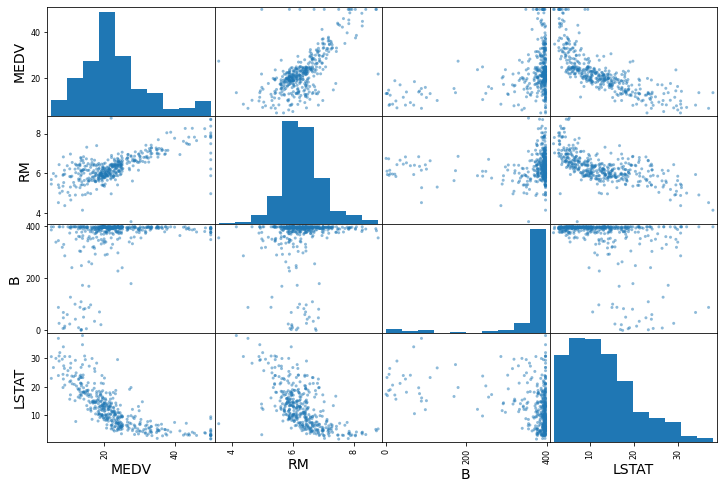

In [122]:
from pandas.plotting import scatter_matrix
attributes = ["MEDV", "RM", "B", "LSTAT"]

scatter_matrix(boston[attributes], figsize=(12, 8))

O objetivo deste projeto é elaborar um modelo que tenha a capacidade de prever o valor das casas. Para isso, note que as características que tem maior correlação com o valor das casas é o RM e o LSTAT:

(3.0, 9.5, 0.0, 55.0)

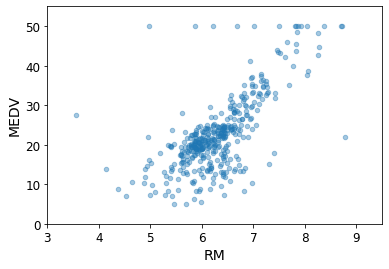

In [123]:
boston.plot(kind="scatter", x="RM", y="MEDV",
             alpha=0.4)
plt.axis([3, 9.5, 0, 55])

(0.0, 45.0, 0.0, 60.0)

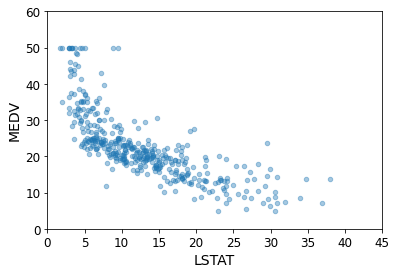

In [124]:
boston.plot(kind="scatter", x="LSTAT", y="MEDV",
             alpha=0.4)
plt.axis([0, 45, 0, 60])

Pelas plotagens, vemos que em ambos os casos a correlação é forte.

# Preparando os dados para os algoritmos de Machine Learning

In [125]:
boston = strat_train_set.drop("MEDV", axis=1)
boston_labels = strat_train_set["MEDV"].copy()

Existem dados faltantes?

In [126]:
sample_incomplete_rows = boston[boston.isnull().any(axis=1)].head() 
sample_incomplete_rows

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT


A reposta é não! Agora vamos criar agora o pipeline, que será aprendido no conjunto de treino e depois será aplicado, usando as regras aprendidas no treinamento, no conjunto de teste. Esse procedimento de usar somente o conjunto de treino é muito importante para evitar o **DATA LEAKAGE**, ou seja, evitar que informações de fora do conjunto de treinamento sejam usadas para criar o modelo. Isso pois essas informações adicionais podem permitir que o modelo aprenda ou saiba algo que de outra forma não saberia e, por sua vez, invalida o desempenho estimado do modo que está sendo construído.

In [127]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
num_pipeline = Pipeline([
        ('std_scaler', StandardScaler()),
    ])

boston_prepared = num_pipeline.fit_transform(boston)

boston_prepared

array([[ 0.38767591, -0.50150974,  0.99710437, ...,  0.83862835,
        -4.01194497,  1.45287772],
       [-0.24718877, -0.50150974,  1.21043345, ..., -1.74230266,
         0.18309816, -1.49470448],
       [-0.38946875,  0.00531919, -0.47746082, ..., -1.50767257,
         0.32071083,  2.36066741],
       ...,
       [ 0.13333619, -0.50150974,  0.99710437, ...,  0.83862835,
        -1.16144525,  0.5136435 ],
       [-0.40567711, -0.50150974, -1.19528435, ..., -0.19374406,
         0.43655362, -0.88495418],
       [-0.40416922, -0.50150974, -1.19528435, ..., -0.19374406,
         0.39854094, -1.2431483 ]])

In [128]:
boston_prepared.shape

(404, 13)

# Selecionando e treinando modelos

Aqui precisamos escolher uma métrica. Optaremos pelo MSE. Devido a definição do MSE (tomamos o quadrado do erro), o efeito de erros maiores se torna consideravelmente mais expressivo do que o efeito dos erros menores, de sorte que o modelo vai concentrar seus esforços em eliminar os erros maiores. Por isso escolhemos essa métrica, pois queremos prever o valor dos imóveis em questão evitando erros grandes.

Começaremos com um modelo simples, a regressão linear:

In [129]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(boston_prepared, boston_labels) 

LinearRegression()

In [130]:
from sklearn.metrics import mean_squared_error as MSE

boston_predictions = lin_reg.predict(boston_prepared)
lin_mse = MSE(boston_labels, boston_predictions)
lin_rmse = np.sqrt(lin_mse) #Não é necessariamente obrigatório
lin_rmse

4.733447309099182

Como esse é um dos algoritmos mais simples, vamos tentar melhorar os resultados usando o decision tree. Testaremos 3 configurações nesse caso:

In [131]:
from sklearn.tree import DecisionTreeRegressor

In [132]:
tree_reg_1 = DecisionTreeRegressor(max_depth=20, random_state=seed)
tree_reg_1.fit(boston_prepared, boston_labels)

DecisionTreeRegressor(max_depth=20, random_state=19)

In [133]:
boston_predictions = tree_reg_1.predict(boston_prepared)
tree_1_mse = MSE(boston_labels, boston_predictions)
tree_1_rmse = np.sqrt(tree_1_mse)
tree_1_rmse

0.0

In [134]:
tree_reg_2 = DecisionTreeRegressor(max_depth=20, min_samples_leaf= 2, random_state=seed)
tree_reg_2.fit(boston_prepared, boston_labels)

DecisionTreeRegressor(max_depth=20, min_samples_leaf=2, random_state=19)

In [135]:
boston_predictions = tree_reg_2.predict(boston_prepared)
tree_2_mse = MSE(boston_labels, boston_predictions)
tree_2_rmse = np.sqrt(tree_2_mse)
tree_2_rmse

1.0957576458696732

In [136]:
tree_reg_3 = DecisionTreeRegressor(max_depth=20,  min_samples_leaf= 4, random_state=seed)
tree_reg_3.fit(boston_prepared, boston_labels)

DecisionTreeRegressor(max_depth=20, min_samples_leaf=4, random_state=19)

In [137]:
boston_predictions = tree_reg_3.predict(boston_prepared)
tree_3_mse = MSE(boston_labels, boston_predictions)
tree_3_rmse = np.sqrt(tree_3_mse)
tree_3_rmse

2.5770927306715143

Note que o decision tree está se sobreajustando ao conjunto de treinamento. Por isso, vamos testar agora outro algoritmo: o random forest.

In [138]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=10, random_state=seed)
forest_reg.fit(boston_prepared, boston_labels) #Treinar modelo

RandomForestRegressor(n_estimators=10, random_state=19)

In [139]:
boston_predictions = forest_reg.predict(boston_prepared) #Predizer
forest_mse = MSE(boston_labels, boston_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

1.5290579834759974

# Valindando os modelos

Para realizarmos a validação, usaremos a validação cruzada. No nosso caso, separaremos o conjunto de treinamento em cv=10 partes. Vale ressaltar que o cross validation age da seguinte forma: para cada parte k ele treina o modelo no conjunto treino∖k e então testa o modelo no conjunto k. 



In [140]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [141]:
from sklearn.model_selection import cross_val_score

lin_scores = cross_val_score(lin_reg, boston_prepared, boston_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [5.05774417 3.6472695  5.08554232 4.32725253 2.98203504 7.05169653
 3.45228314 5.63044714 4.52310147 6.28708895]
Mean: 4.804446079044981
Standard deviation: 1.2193961604528814


In [142]:
scores = cross_val_score(tree_reg_1, boston_prepared, boston_labels,
                         scoring="neg_mean_squared_error", cv=10) 
tree_1_rmse_scores = np.sqrt(-scores)
display_scores(tree_1_rmse_scores)

Scores: [3.58785213 3.76352844 4.09059003 4.26325766 3.11921464 5.16059051
 4.09197385 3.27062685 6.60210194 5.796486  ]
Mean: 4.374622207057814
Standard deviation: 1.0752381992298332


In [143]:
scores = cross_val_score(tree_reg_2, boston_prepared, boston_labels,
                         scoring="neg_mean_squared_error", cv=10) 
tree_2_rmse_scores = np.sqrt(-scores)
display_scores(tree_2_rmse_scores)

Scores: [4.0518439  2.8731504  3.68961224 4.68507476 3.0053494  4.4131464
 3.01341561 3.74347766 7.0745205  6.48207732]
Mean: 4.303166817996368
Standard deviation: 1.3686343909094627


In [144]:
scores = cross_val_score(tree_reg_3, boston_prepared, boston_labels,
                         scoring="neg_mean_squared_error", cv=10) 
tree_3_rmse_scores = np.sqrt(-scores)
display_scores(tree_3_rmse_scores)

Scores: [5.17762118 2.60297458 4.06956166 5.23953231 2.62302844 4.32215853
 4.54329979 5.86757102 7.02810881 6.00458279]
Mean: 4.747843911553001
Standard deviation: 1.351209599126376


In [145]:
forest_scores = cross_val_score(forest_reg, boston_prepared, boston_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [3.38948697 2.24643186 4.06722594 4.03890803 2.20502551 3.37577028
 2.04851532 3.27699291 4.01501993 4.95927843]
Mean: 3.3622655162536885
Standard deviation: 0.9082827978632225


Embora o decision tree teve melhores erros no conjunto de treinamento, ele foi quase tão ruim quanto a regressão linear no processo de validação cruzada (efeito devido ao sobreajuste no conjunto de treino). Por isso, vamos ficar com o modelo do random forest. Usaremos o gridsearch para testar e encontrar os melhores parâmetros para esse algoritmo:

In [146]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # Vamos tentar 12 = 3x4 combinação de parâmetros
    {'n_estimators': [3, 7, 10, 30, 100], 'max_features': [2, 3, 4, 6, 8, 10]},
    # Tentar 6 = 2×3 combinações do bootstrap no modo 'Falso'
    {'bootstrap': [False], 'n_estimators': [3, 7, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=seed)

# Vamos treinar com 5-folds, então temos (12+6)*5=90 rodadas de treinamento!!!

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search.fit(boston_prepared, boston_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=19),
             param_grid=[{'max_features': [2, 3, 4, 6, 8, 10],
                          'n_estimators': [3, 7, 10, 30, 100]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 7, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [147]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [148]:
grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30, random_state=19)

In [149]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

5.037268965929514 {'max_features': 2, 'n_estimators': 3}
4.333159807415794 {'max_features': 2, 'n_estimators': 7}
4.127809461146537 {'max_features': 2, 'n_estimators': 10}
3.7530371474642927 {'max_features': 2, 'n_estimators': 30}
3.6848429968563763 {'max_features': 2, 'n_estimators': 100}
4.247275657925123 {'max_features': 3, 'n_estimators': 3}
4.131385584073856 {'max_features': 3, 'n_estimators': 7}
3.973492145098627 {'max_features': 3, 'n_estimators': 10}
3.7188176951913885 {'max_features': 3, 'n_estimators': 30}
3.500644320781144 {'max_features': 3, 'n_estimators': 100}
4.562865284999492 {'max_features': 4, 'n_estimators': 3}
3.9476943096967108 {'max_features': 4, 'n_estimators': 7}
3.9489223698011653 {'max_features': 4, 'n_estimators': 10}
3.556903173434046 {'max_features': 4, 'n_estimators': 30}
3.469016666301885 {'max_features': 4, 'n_estimators': 100}
4.439157604005084 {'max_features': 6, 'n_estimators': 3}
3.548625137868271 {'max_features': 6, 'n_estimators': 7}
3.505133686536

#O Teste Final

Por fim, vamos realizar o teste final para encontrar um erro aproximado para o modelo:

In [150]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("MEDV", axis=1)
y_test = strat_test_set["MEDV"].copy()

X_test_prepared = num_pipeline.fit_transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = MSE(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

3.263282610913864